In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [104]:
from meteostat import Point, Monthly

# Set time period
start = datetime.datetime(1970, 3, 1)
end = datetime.datetime(2022, 12, 31)

# Create Point for Madrid
location = Point(40.416775, -3.703790, 657)

# Get daily data for March 2023
df_madrid = Monthly(location, start, end)
df_madrid = df_madrid.fetch()

In [105]:
df_madrid

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
1970-03-01,9.5,3.2,12.9,14.6,NaN,1016.0,NaN
1970-04-01,12.8,7.3,18.9,1.4,NaN,1021.0,NaN
1970-05-01,16.2,11.0,22.0,18.8,NaN,1016.0,NaN
1970-06-01,20.3,15.5,25.8,17.7,NaN,1016.0,NaN
1970-07-01,24.3,18.1,31.2,11.5,NaN,1016.0,NaN
...,...,...,...,...,...,...,...
2022-08-01,27.4,21.4,34.3,4.9,10.1,1013.8,NaN
2022-09-01,20.9,16.1,26.8,43.9,10.2,1014.6,NaN
2022-10-01,17.7,14.1,22.9,27.8,8.0,1019.8,NaN


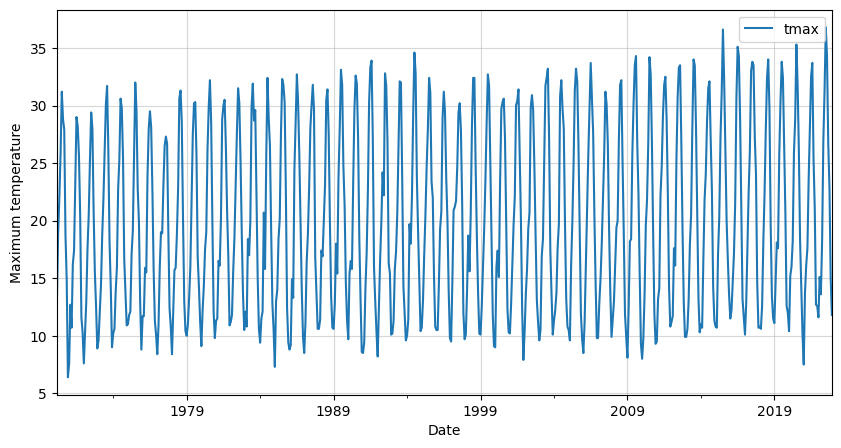

In [106]:
# Keep only the maximum temperature
df_temp_max = df_madrid[['tmax']]

# Visualize the data
df_temp_max.plot(figsize=(10,5))
plt.grid(alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.show()

In [107]:
df_temp_max.isna().sum()


tmax    0
dtype: int64

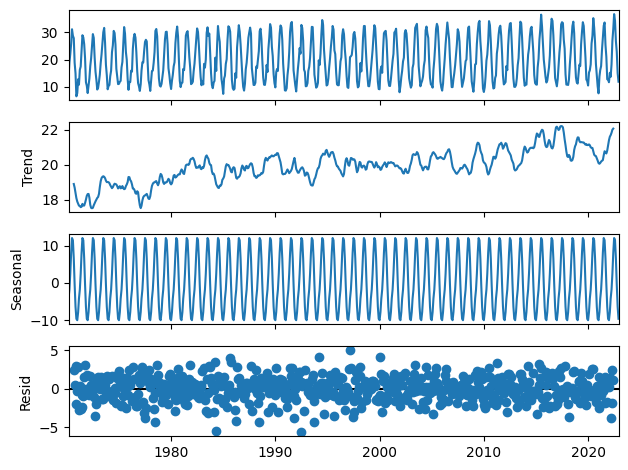

In [108]:
# Import statsmodels library
import statsmodels.api as sm

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df_temp_max, 
                                          model='additive', 
                                          period=12)

# Extract the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
decomposition.plot()
plt.show()

### Prophet

In [109]:
df_temp_max

,tmax
time,
1970-03-01,12.9
1970-04-01,18.9
1970-05-01,22.0
1970-06-01,25.8
1970-07-01,31.2
...,...
2022-08-01,34.3
2022-09-01,26.8
2022-10-01,22.9


In [110]:
df_temp_max.reset_index(inplace=True)
df_temp_max

,time,tmax
0,1970-03-01,12.9
1,1970-04-01,18.9
2,1970-05-01,22.0
3,1970-06-01,25.8
4,1970-07-01,31.2
...,...,...
629,2022-08-01,34.3
630,2022-09-01,26.8
631,2022-10-01,22.9
632,2022-11-01,15.0


17:09:16 - cmdstanpy - INFO - Chain [1] start processing
17:09:17 - cmdstanpy - INFO - Chain [1] done processing


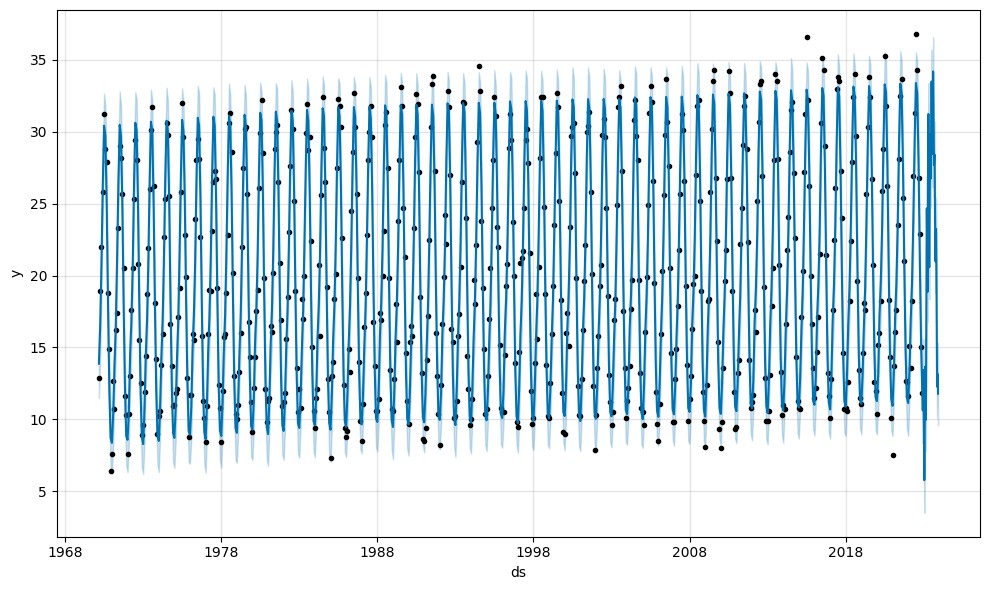

In [111]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Veriyi Prophet için uygun formata dönüştürme
df_prophet = df_temp_max.rename(columns={'time': 'ds', 'tmax': 'y'})

# Prophet modelini oluşturma
model = Prophet()
model.fit(df_prophet)

# Gelecekteki değerler için tahmin yapma
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Bileşenleri görselleştirme
fig1 = model.plot(forecast)
plt.show()


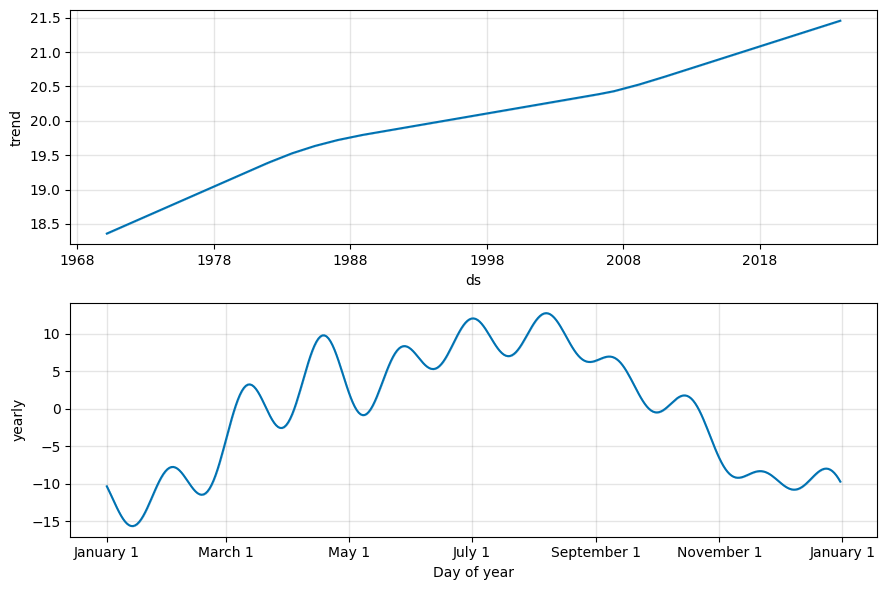

In [112]:
fig2 = model.plot_components(forecast)

### Check for stationarity

In [113]:
df_temp_max=df_madrid[['tmax']]

In [114]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(df_temp_max)

# Extract and print the test statistics and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test statistics : {test_statistic}")
print(f"P value less 0.05 --> stationary  {p_value}")

Test statistics : -2.971872590243201
P value less 0.05 --> stationary  0.03760595188739098


### Kwiatkowski–Phillips–Schmidt–Shin (KPSS)

In [115]:
from statsmodels.tsa.stattools import kpss

# Perform KPSS test
result = kpss(df_temp_max)

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value bigger than 0.05 ---> stationary {p_value}")

Test Statistic: 0.23003042556646808
P-value bigger than 0.05 ---> stationary 0.1


look-up table. The actual p-value is greater than the p-value returned.



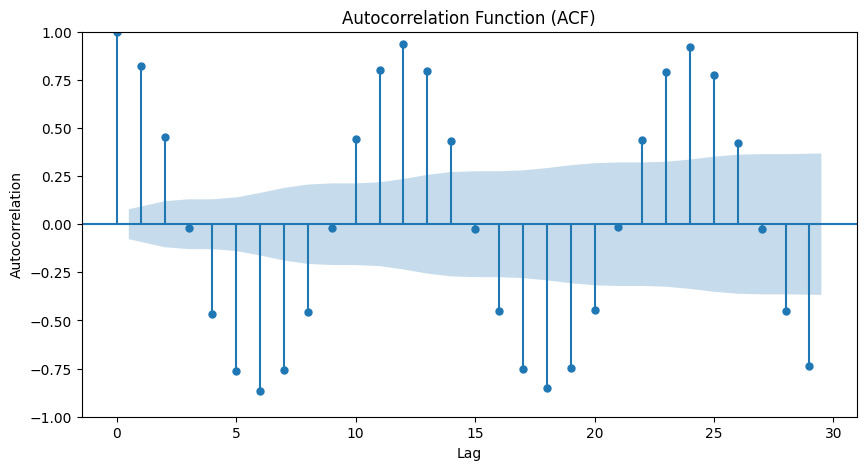

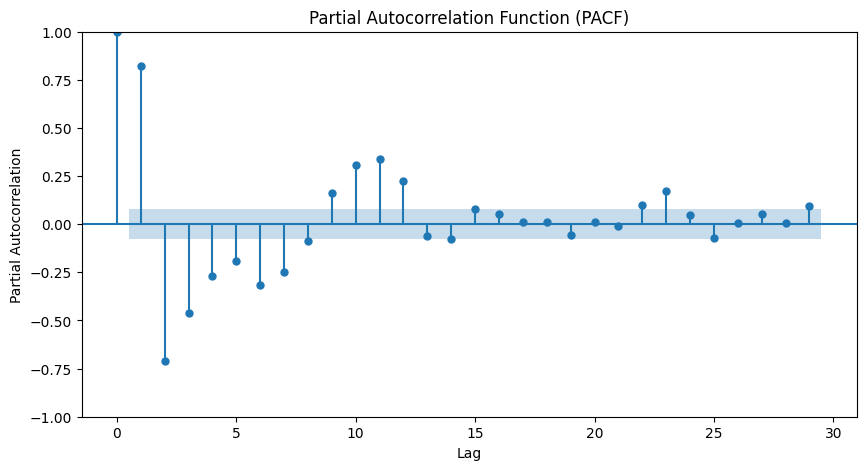

In [116]:
# ACF PACF 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df_temp_max, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df_temp_max, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

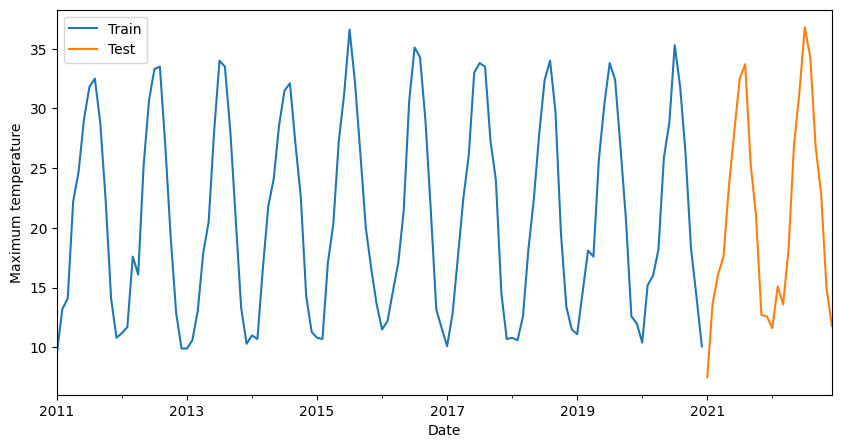

In [117]:
# Split into training and testing
df_train = df_temp_max.loc[:'2020']
df_test = df_temp_max.loc['2021':]

# Plot the last 10 years of training data and the 2 of testing
ax = df_train[-120:].plot(figsize=(10, 5))
df_test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.show()

In [118]:
df_temp_max

,tmax
time,
1970-03-01,12.9
1970-04-01,18.9
1970-05-01,22.0
1970-06-01,25.8
1970-07-01,31.2
...,...
2022-08-01,34.3
2022-09-01,26.8
2022-10-01,22.9


## model 찾기

In [119]:
df_temp_max

,tmax
time,
1970-03-01,12.9
1970-04-01,18.9
1970-05-01,22.0
1970-06-01,25.8
1970-07-01,31.2
...,...
2022-08-01,34.3
2022-09-01,26.8
2022-10-01,22.9


In [120]:
df_train.reset_index(inplace=True)

In [121]:
df_train

,time,tmax
0,1970-03-01,12.9
1,1970-04-01,18.9
2,1970-05-01,22.0
3,1970-06-01,25.8
4,1970-07-01,31.2
...,...,...
605,2020-08-01,31.8
606,2020-09-01,26.2
607,2020-10-01,18.3
608,2020-11-01,14.3


In [122]:
df_train=df_train.rename(columns={"time":"Date","tmax":"y"})

In [123]:
df_test.reset_index(inplace=True)
df_test=df_test.rename(columns={"time":"Date","tmax":"y"})

In [124]:
'''from auto_ts import auto_timeseries
import pandas as pd
strf_time_format = "%Y-%m-%d"
# Veri çerçevesini yükleyin
# Örnek veride 'Date' sütunu ve 'y' sütunu olduğunu varsayıyoruz
data = df_train

# Veri çerçevesini kontrol edin
print(data.head())  # İlk birkaç satırı kontrol edin
print(data.columns)  # Sütun adlarını kontrol edin


model = auto_timeseries(score_type='rmse', 
                        time_interval='M', 
                        non_seasonal_pdq=None, 
                        seasonality=False, 
                        seasonal_period=12, 
                        model_type=['best'], 
                        verbose=2, 
                        dask_xgboost_flag=0,
                        strf_time_format=strf_time_format)

# Modeli eğitme
model.fit(traindata=data, ts_column='Date', target='y')

# Gelecek veriler için tahmin yapma
# testdata, test seti veya ileriye yönelik tahminler için kullanılacak veriyi içerir
testdata = df_test
predictions = model.predict(testdata, model='best')
print(predictions)'''


'from auto_ts import auto_timeseries\nimport pandas as pd\nstrf_time_format = "%Y-%m-%d"\n# Veri çerçevesini yükleyin\n# Örnek veride \'Date\' sütunu ve \'y\' sütunu olduğunu varsayıyoruz\ndata = df_train\n\n# Veri çerçevesini kontrol edin\nprint(data.head())  # İlk birkaç satırı kontrol edin\nprint(data.columns)  # Sütun adlarını kontrol edin\n\n\nmodel = auto_timeseries(score_type=\'rmse\', \n                        time_interval=\'M\', \n                        non_seasonal_pdq=None, \n                        seasonality=False, \n                        seasonal_period=12, \n                        model_type=[\'best\'], \n                        verbose=2, \n                        dask_xgboost_flag=0,\n                        strf_time_format=strf_time_format)\n\n# Modeli eğitme\nmodel.fit(traindata=data, ts_column=\'Date\', target=\'y\')\n\n# Gelecek veriler için tahmin yapma\n# testdata, test seti veya ileriye yönelik tahminler için kullanılacak veriyi içerir\ntestdata = df_test

### Model Manual Grid Search

In [125]:
df_train = df_temp_max.loc[:'2020']
df_test = df_temp_max.loc['2021':]

In [126]:
import itertools
import math

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = sm.tsa.SARIMAX(df_train, 
                               order=order, 
                               seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(0, 0, 0) (0, 0, 0, 12) 5471.171017366447
(0, 0, 0) (0, 0, 1, 12) 4755.531108034635
(0, 0, 0) (1, 0, 0, 12) 2807.037567597904


(0, 0, 0) (1, 0, 1, 12) 2495.7206995950114
(0, 0, 1) (0, 0, 0, 12) 4738.463525441684


(0, 0, 1) (0, 0, 1, 12) 4158.49284580789


(0, 0, 1) (1, 0, 0, 12) 2774.9066952418134


(0, 0, 1) (1, 0, 1, 12) 2465.3748335252812
(0, 0, 2) (0, 0, 0, 12) 4243.9352354742205


(0, 0, 2) (0, 0, 1, 12) 3882.0060978979773


(0, 0, 2) (1, 0, 0, 12) 2766.7676303568724


(0, 0, 2) (1, 0, 1, 12) 2458.3402520327427
(1, 0, 0) (0, 0, 0, 12) 3608.6351931886247
(1, 0, 0) (0, 0, 1, 12) 3288.4677539389613
(1, 0, 0) (1, 0, 0, 12) 2768.1940545514626


(1, 0, 0) (1, 0, 1, 12) 2458.2712044309396
(1, 0, 1) (0, 0, 0, 12) 3435.3925302674907
(1, 0, 1) (0, 0, 1, 12) 3250.53675916754
(1, 0, 1) (1, 0, 0, 12) 2768.3590289410145


(1, 0, 1) (1, 0, 1, 12) 2463.9888775951167
(1, 0, 2) (0, 0, 0, 12) 3346.2318147637366
(1, 0, 2) (0, 0, 1, 12) 3200.8842293756384


(1, 0, 2) (1, 0, 0, 12) 2747.6207361308793


(1, 0, 2) (1, 0, 1, 12) 2442.5868704760833
(2, 0, 0) (0, 0, 0, 12) 3350.2113890997543
(2, 0, 0) (0, 0, 1, 12) 3225.0056253306097
(2, 0, 0) (1, 0, 0, 12) 2767.658132945013


(2, 0, 0) (1, 0, 1, 12) 2457.3956266247887
(2, 0, 1) (0, 0, 0, 12) 3352.2113837840684
(2, 0, 1) (0, 0, 1, 12) 3220.6412732930767
(2, 0, 1) (1, 0, 0, 12) 2772.1172603439227


(2, 0, 1) (1, 0, 1, 12) 2440.5100267919584
(2, 0, 2) (0, 0, 0, 12) 3313.1117876447825
(2, 0, 2) (0, 0, 1, 12) 3188.8753722953247
(2, 0, 2) (1, 0, 0, 12) 2770.7681968285


(2, 0, 2) (1, 0, 1, 12) 2441.31983835827
Best Parameters: (2, 0, 1, 1, 0, 1, 12)
Best AIC: 2440.5100267919584


In [127]:
model = sm.tsa.SARIMAX(df_train,
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result = model.fit(disp=False)

# Show the summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               tmax   No. Observations:                  610
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -1214.255
Date:                            Thu, 01 Aug 2024   AIC                           2440.510
Time:                                    17:09:44   BIC                           2466.991
Sample:                                03-01-1970   HQIC                          2450.811
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2328      0.031     39.785      0.000       1.172       1.294
ar.L2         -0.2357      0.032     -7.371      0.000      -0.298      -0.173
ma.L1         -0.9843      0.015    -65.662      0.000      -1.014      -0.955
ar.S.L12       0.9989      0.001   1604.986      0.000       0.998       1.000
ma.S.L12      -0.8517      0.027    -31.517      0.000      -0.905      -0.799
sigma2         2.9016      0.148     19.631      0.000       2.612       3.191
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.77
Prob(Q):                              0.87   Prob(JB):                         0.15
Heteroskedasticity (H):               0.75   Skew:                            -0.16
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

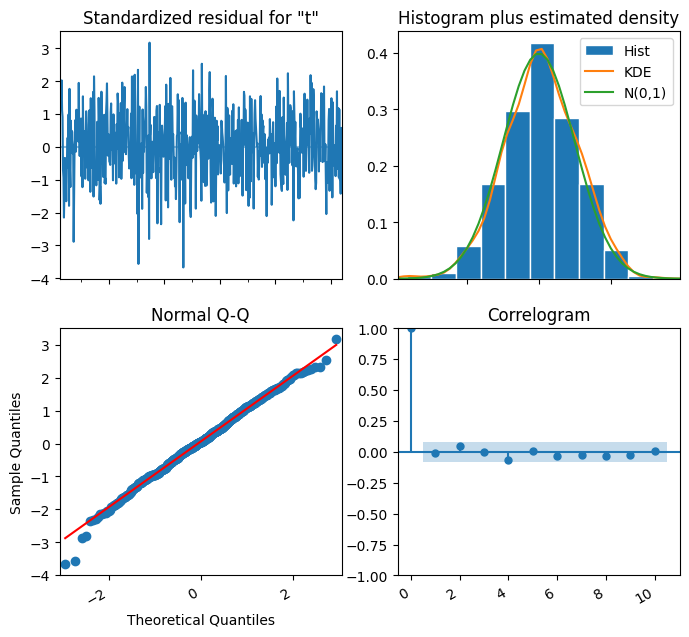

In [128]:
# Display the model diagnostics
fig = result.plot_diagnostics(figsize=(8, 8))
fig.autofmt_xdate()
plt.show()

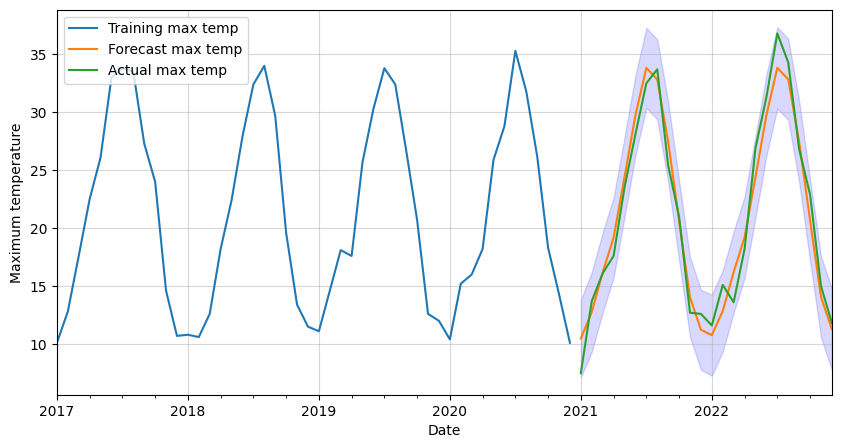

In [129]:
# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=24)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot forecast with training data
ax = df_train[-12*4:].plot(figsize=(10,5))
forecast_values.plot()
df_test.plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals['lower tmax'], 
                 confidence_intervals['upper tmax'], 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training max temp', 
            'Forecast max temp', 
            'Actual max temp'], 
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.grid(alpha=0.5)
plt.show()

In [130]:
# Predicted values and actual values
predicted_values = forecast_values.values
actual_values = df_test.values.flatten()

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(predicted_values - actual_values))
print("MAE:", mae)

# Root Mean Squared Error (RMSE)
mse = np.mean((predicted_values - actual_values) ** 2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predicted_values - actual_values) / actual_values)) * 100
print("MAPE:", mape)

MAE: 1.4569389654497853
RMSE: 1.658247956123041
MAPE: 8.32826951067223


### AutoARIMA

In [131]:
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(df_train, 
                   seasonal=True, 
                   m=12, 
                   suppress_warnings=True)
model.fit(df_train)

# Check the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  610
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood               -1216.861
Date:                              Thu, 01 Aug 2024   AIC                           2445.721
Time:                                      17:10:34   BIC                           2472.202
Sample:                                  03-01-1970   HQIC                          2456.022
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0564      0.023      2.486      0.013       0.012       0.101
ma.L1          0.2375      0.038      6.226      0.000       0.163       0.312
ma.L2          0.1341      0.040      3.332      0.001       0.055       0.213
ar.S.L12       0.9974      0.001    903.685      0.000       0.995       1.000
ma.S.L12      -0.8335      0.026    -32.203      0.000      -0.884      -0.783
sigma2         2.9227      0.172     16.958      0.000       2.585       3.261
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.88
Prob(Q):                              0.78   Prob(JB):                         0.09
Heteroskedasticity (H):               0.72   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

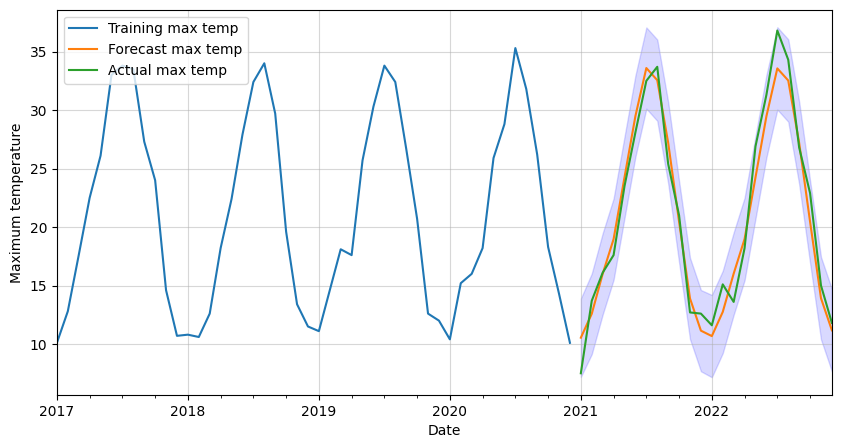

In [132]:
# Make predictions
forecast_auto, conf_int_auto = model.predict(n_periods=24,
                                             return_conf_int=True)

# Get forecast and confidence intervals for two years
forecast_values_auto = forecast_auto
confidence_intervals_auto = conf_int_auto

# Plot forecast with training data
ax = df_train[-12*4:].plot(figsize=(10,5))
forecast_auto.plot(ax=ax)
df_test.plot(ax=ax)
plt.fill_between(forecast_values_auto.index, 
                 confidence_intervals_auto[:,[0]].flatten(), 
                 confidence_intervals_auto[:,[1]].flatten(), 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training max temp', 
            'Forecast max temp', 
            'Actual max temp'], 
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.grid(alpha=0.5)
plt.show()

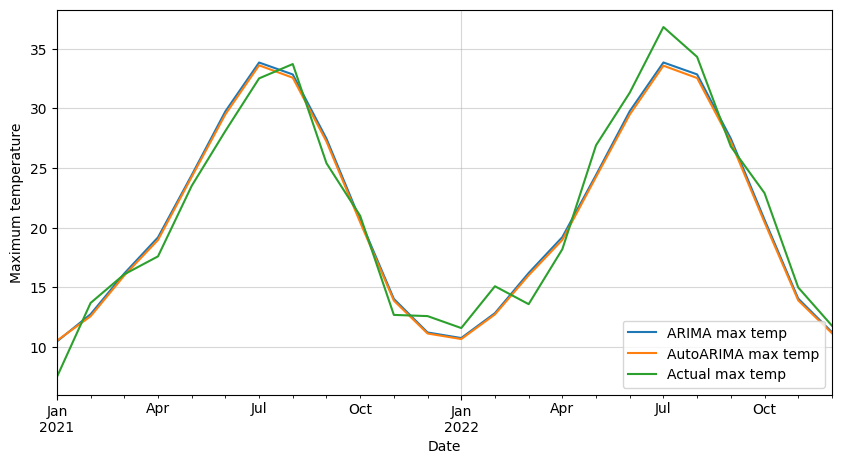

In [133]:
# Plot both forecasts against actual data
ax = forecast_values.plot(figsize=(10,5))
forecast_auto.plot(ax=ax)
df_test.plot(ax=ax)

plt.legend(['ARIMA max temp', 
            'AutoARIMA max temp', 
            'Actual max temp'], 
           loc='lower right')
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.grid(alpha=0.5)
plt.show()

# Prophet Model

In [134]:
df_train.reset_index(inplace=True)
df_train=df_train.rename(columns={"time":"Date","tmax":"y"})
df_test.reset_index(inplace=True)
df_test=df_test.rename(columns={"time":"Date","tmax":"y"})

In [135]:
from prophet import Prophet
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
import pandas as pd
import numpy as np

# Veri çerçevesini yükleyin
data = df_train.copy()
data.rename(columns={'Date': 'ds', 'y': 'y'}, inplace=True)

# Hiperparametre aralıklarını belirleme
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Cross-validation split
tscv = TimeSeriesSplit(n_splits=3)

# En iyi hiperparametreleri bulmak için değişkenler
best_params = None
best_rmse = float('inf')

# Grid search
for params in ParameterGrid(param_grid):
    rmses = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        model = Prophet(**params)
        model.fit(train_data)
        
        # Gelecekteki verileri tahmin et
        future = model.make_future_dataframe(periods=len(test_data), freq='ME')
        forecast = model.predict(future)
        
        # Sadece test verilerinin tahminlerini al
        forecast_test = forecast.iloc[-len(test_data):]
        
        # RMSE hesapla
        rmse = np.sqrt(np.mean((forecast_test['yhat'] - test_data['y'])**2))
        rmses.append(rmse)
    
    mean_rmse = np.mean(rmses)
    print(f"Params: {params}, RMSE: {mean_rmse}")
    
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params

print(f"En İyi Parametreler: {best_params}")
print(f"En İyi RMSE: {best_rmse}")


17:10:35 - cmdstanpy - INFO - Chain [1] start processing
17:10:35 - cmdstanpy - INFO - Chain [1] done processing
17:10:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:35 - cmdstanpy - INFO - Chain [1] start processing
17:10:35 - cmdstanpy - INFO - Chain [1] done processing
17:10:36 - cmdstanpy - INFO - Chain [1] start processing
17:10:36 - cmdstanpy - INFO - Chain [1] done processing
17:10:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:36 - cmdstanpy - INFO - Chain [1] start processing
17:10:36 - cmdstanpy - INFO - Chain [1] done processing
17:10:36 - cmdstanpy - INFO - Chain [1] start processing
17:10:36 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, RMSE: 2.350056174858796


17:10:37 - cmdstanpy - INFO - Chain [1] start processing
17:10:37 - cmdstanpy - INFO - Chain [1] done processing
17:10:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:37 - cmdstanpy - INFO - Chain [1] start processing
17:10:37 - cmdstanpy - INFO - Chain [1] done processing
17:10:38 - cmdstanpy - INFO - Chain [1] start processing
17:10:38 - cmdstanpy - INFO - Chain [1] done processing
17:10:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:38 - cmdstanpy - INFO - Chain [1] start processing
17:10:38 - cmdstanpy - INFO - Chain [1] done processing
17:10:38 - cmdstanpy - INFO - Chain [1] start processing
17:10:38 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, RMSE: 2.576582778137548


17:10:39 - cmdstanpy - INFO - Chain [1] start processing
17:10:39 - cmdstanpy - INFO - Chain [1] done processing
17:10:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:39 - cmdstanpy - INFO - Chain [1] start processing
17:10:39 - cmdstanpy - INFO - Chain [1] done processing
17:10:39 - cmdstanpy - INFO - Chain [1] start processing
17:10:39 - cmdstanpy - INFO - Chain [1] done processing
17:10:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:39 - cmdstanpy - INFO - Chain [1] start processing
17:10:40 - cmdstanpy - INFO - Chain [1] done processing
17:10:40 - cmdstanpy - INFO - Chain [1] start processing
17:10:40 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, RMSE: 2.5279135132999646


17:10:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:41 - cmdstanpy - INFO - Chain [1] done processing
17:10:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:41 - cmdstanpy - INFO - Chain [1] done processing
17:10:42 - cmdstanpy - INFO - Chain [1] start processing
17:10:42 - cmdstanpy - INFO - Chain [1] done processing
17:10:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:42 - cmdstanpy - INFO - Chain [1] start processing
17:10:42 - cmdstanpy - INFO - Chain [1] done processing
17:10:43 - cmdstanpy - INFO - Chain [1] start processing
17:10:43 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, RMSE: 3.0187284284256806


17:10:43 - cmdstanpy - INFO - Chain [1] start processing
17:10:43 - cmdstanpy - INFO - Chain [1] done processing
17:10:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:43 - cmdstanpy - INFO - Chain [1] start processing
17:10:44 - cmdstanpy - INFO - Chain [1] done processing
17:10:44 - cmdstanpy - INFO - Chain [1] start processing
17:10:44 - cmdstanpy - INFO - Chain [1] done processing
17:10:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:44 - cmdstanpy - INFO - Chain [1] start processing
17:10:44 - cmdstanpy - INFO - Chain [1] done processing
17:10:45 - cmdstanpy - INFO - Chain [1] start processing
17:10:45 - cmdstanpy - INFO - Chain [1] done processing
17:10:45 - cmdstanpy - INFO - Chain [1] start processing
17:10:45 - cmdstanpy - INFO - Chain [1] done processing
17:10:45 -

Params: {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, RMSE: 2.1784509152253633


17:10:45 - cmdstanpy - INFO - Chain [1] done processing
17:10:46 - cmdstanpy - INFO - Chain [1] start processing
17:10:46 - cmdstanpy - INFO - Chain [1] done processing
17:10:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:10:46 - cmdstanpy - INFO - Chain [1] start processing
17:10:46 - cmdstanpy - INFO - Chain [1] done processing
17:10:47 - cmdstanpy - INFO - Chain [1] start processing
17:10:47 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, RMSE: 2.980188125157292


17:10:47 - cmdstanpy - INFO - Chain [1] start processing
17:10:47 - cmdstanpy - INFO - Chain [1] done processing
17:10:47 - cmdstanpy - INFO - Chain [1] start processing
17:10:47 - cmdstanpy - INFO - Chain [1] done processing
17:10:48 - cmdstanpy - INFO - Chain [1] start processing
17:10:48 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, RMSE: 1.944251592827598


17:10:48 - cmdstanpy - INFO - Chain [1] start processing
17:10:48 - cmdstanpy - INFO - Chain [1] done processing
17:10:49 - cmdstanpy - INFO - Chain [1] start processing
17:10:49 - cmdstanpy - INFO - Chain [1] done processing
17:10:49 - cmdstanpy - INFO - Chain [1] start processing
17:10:49 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, RMSE: 1.9594226130678418


17:10:50 - cmdstanpy - INFO - Chain [1] start processing
17:10:50 - cmdstanpy - INFO - Chain [1] done processing
17:10:50 - cmdstanpy - INFO - Chain [1] start processing
17:10:50 - cmdstanpy - INFO - Chain [1] done processing
17:10:50 - cmdstanpy - INFO - Chain [1] start processing
17:10:50 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, RMSE: 1.9623950222894742


17:10:51 - cmdstanpy - INFO - Chain [1] start processing
17:10:51 - cmdstanpy - INFO - Chain [1] done processing
17:10:51 - cmdstanpy - INFO - Chain [1] start processing
17:10:51 - cmdstanpy - INFO - Chain [1] done processing
17:10:52 - cmdstanpy - INFO - Chain [1] start processing
17:10:52 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, RMSE: 1.8255388836803377


17:10:52 - cmdstanpy - INFO - Chain [1] start processing
17:10:52 - cmdstanpy - INFO - Chain [1] done processing
17:10:52 - cmdstanpy - INFO - Chain [1] start processing
17:10:53 - cmdstanpy - INFO - Chain [1] done processing
17:10:53 - cmdstanpy - INFO - Chain [1] start processing
17:10:53 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, RMSE: 1.8290704866724372


17:10:53 - cmdstanpy - INFO - Chain [1] start processing
17:10:53 - cmdstanpy - INFO - Chain [1] done processing
17:10:54 - cmdstanpy - INFO - Chain [1] start processing
17:10:54 - cmdstanpy - INFO - Chain [1] done processing
17:10:54 - cmdstanpy - INFO - Chain [1] start processing
17:10:54 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, RMSE: 1.8317458745121875


17:10:55 - cmdstanpy - INFO - Chain [1] start processing
17:10:55 - cmdstanpy - INFO - Chain [1] done processing
17:10:55 - cmdstanpy - INFO - Chain [1] start processing
17:10:55 - cmdstanpy - INFO - Chain [1] done processing
17:10:55 - cmdstanpy - INFO - Chain [1] start processing
17:10:56 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, RMSE: 2.15874151816482


17:10:56 - cmdstanpy - INFO - Chain [1] start processing
17:10:56 - cmdstanpy - INFO - Chain [1] done processing
17:10:56 - cmdstanpy - INFO - Chain [1] start processing
17:10:56 - cmdstanpy - INFO - Chain [1] done processing
17:10:57 - cmdstanpy - INFO - Chain [1] start processing
17:10:57 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, RMSE: 2.218059662373664


17:10:57 - cmdstanpy - INFO - Chain [1] start processing
17:10:57 - cmdstanpy - INFO - Chain [1] done processing
17:10:58 - cmdstanpy - INFO - Chain [1] start processing
17:10:58 - cmdstanpy - INFO - Chain [1] done processing
17:10:58 - cmdstanpy - INFO - Chain [1] start processing
17:10:58 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, RMSE: 2.221205988640674


17:10:58 - cmdstanpy - INFO - Chain [1] start processing
17:10:58 - cmdstanpy - INFO - Chain [1] done processing
17:10:59 - cmdstanpy - INFO - Chain [1] start processing
17:10:59 - cmdstanpy - INFO - Chain [1] done processing
17:10:59 - cmdstanpy - INFO - Chain [1] start processing
17:10:59 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, RMSE: 2.0715964470860033


17:11:00 - cmdstanpy - INFO - Chain [1] start processing
17:11:00 - cmdstanpy - INFO - Chain [1] done processing
17:11:00 - cmdstanpy - INFO - Chain [1] start processing
17:11:00 - cmdstanpy - INFO - Chain [1] done processing
17:11:00 - cmdstanpy - INFO - Chain [1] start processing
17:11:00 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, RMSE: 2.154210248670977


17:11:01 - cmdstanpy - INFO - Chain [1] start processing
17:11:01 - cmdstanpy - INFO - Chain [1] done processing
17:11:01 - cmdstanpy - INFO - Chain [1] start processing
17:11:01 - cmdstanpy - INFO - Chain [1] done processing
17:11:02 - cmdstanpy - INFO - Chain [1] start processing
17:11:02 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, RMSE: 2.1792044279873397


17:11:02 - cmdstanpy - INFO - Chain [1] start processing
17:11:02 - cmdstanpy - INFO - Chain [1] done processing
17:11:03 - cmdstanpy - INFO - Chain [1] start processing
17:11:03 - cmdstanpy - INFO - Chain [1] done processing
17:11:03 - cmdstanpy - INFO - Chain [1] start processing
17:11:03 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, RMSE: 2.2727486737750526


17:11:04 - cmdstanpy - INFO - Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing
17:11:04 - cmdstanpy - INFO - Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing
17:11:04 - cmdstanpy - INFO - Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, RMSE: 2.348045432711578


17:11:05 - cmdstanpy - INFO - Chain [1] start processing
17:11:05 - cmdstanpy - INFO - Chain [1] done processing
17:11:05 - cmdstanpy - INFO - Chain [1] start processing
17:11:05 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, RMSE: 2.3726227737997276


17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] done processing
17:11:07 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing
17:11:07 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, RMSE: 2.0198924273104537


17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing
17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing
17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, RMSE: 2.1345681820067255


17:11:09 - cmdstanpy - INFO - Chain [1] start processing
17:11:09 - cmdstanpy - INFO - Chain [1] done processing
17:11:09 - cmdstanpy - INFO - Chain [1] start processing
17:11:09 - cmdstanpy - INFO - Chain [1] done processing
17:11:10 - cmdstanpy - INFO - Chain [1] start processing
17:11:10 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, RMSE: 2.1566723685903333
En İyi Parametreler: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
En İyi RMSE: 1.8255388836803377


17:11:10 - cmdstanpy - INFO - Chain [1] start processing
17:11:10 - cmdstanpy - INFO - Chain [1] done processing


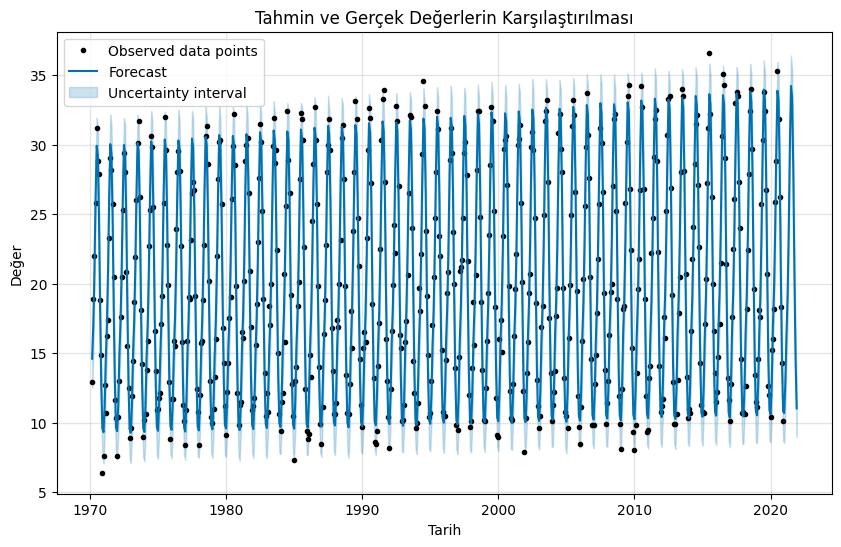

In [136]:
import matplotlib.pyplot as plt
from prophet import Prophet

# En iyi parametrelerle Prophet modelini oluştur
best_model = Prophet(**best_params)
best_model.fit(data)

# Gelecek veriler için tahmin yapma (örneğin, 12 ay ileriye dönük)
future = best_model.make_future_dataframe(periods=12, freq='ME')
forecast = best_model.predict(future)

# Tahminlerin ve gerçek verilerin grafiği
fig, ax = plt.subplots(figsize=(10, 6))
best_model.plot(forecast, ax=ax)
plt.title('Tahmin ve Gerçek Değerlerin Karşılaştırılması')
plt.xlabel('Tarih')
plt.ylabel('Değer')

# Legend'ı düzenleme
handles, labels = ax.get_legend_handles_labels()
labels[0] = "Observed data points"  # "Gerçek Veriler" yerine
labels[1] = "Forecast"  # "Tahmin"
labels[2] = "Uncertainty interval"  # "Güven Aralıkları"

ax.legend(handles, labels)
plt.show()


### Prophet Model Diagnostic

In [137]:
# Artıkların hesaplanması
data['yhat'] = forecast['yhat'][:len(data)]
data['residuals'] = data['y'] - data['yhat']

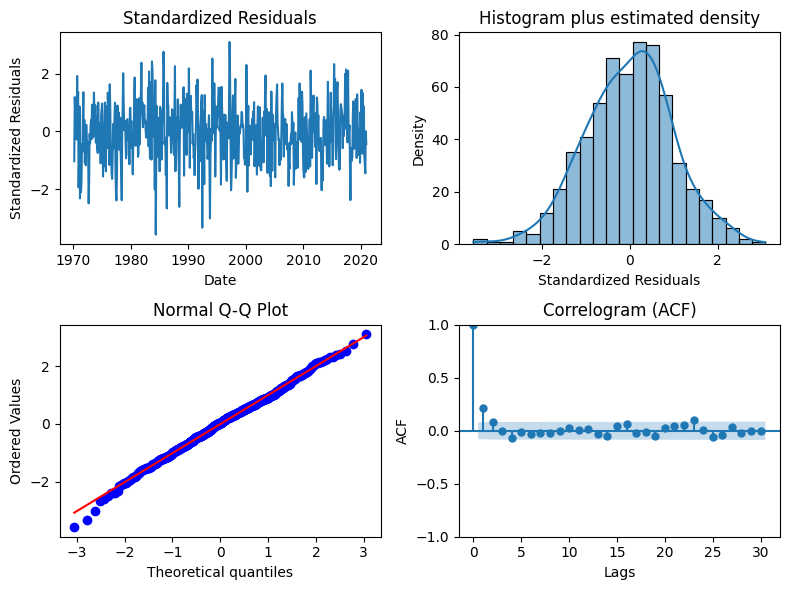

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

# Standardized residuals
data['standardized_residuals'] = data['residuals'] / data['residuals'].std()

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Standardized Residuals Plot
axes[0, 0].plot(data['ds'], data['standardized_residuals'])
axes[0, 0].set_title('Standardized Residuals')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Standardized Residuals')

# Histogram and Density Plot
sns.histplot(data['standardized_residuals'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram plus estimated density')
axes[0, 1].set_xlabel('Standardized Residuals')
axes[0, 1].set_ylabel('Density')

# Q-Q Plot
stats.probplot(data['standardized_residuals'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')

# ACF Plot
sm.graphics.tsa.plot_acf(data['standardized_residuals'], lags=30, ax=axes[1, 1])
axes[1, 1].set_title('Correlogram (ACF)')
axes[1, 1].set_xlabel('Lags')
axes[1, 1].set_ylabel('ACF')

# Layout adjustment
plt.tight_layout()
plt.show()